# Olist's Metric Design 

In this challenge, we are going to catch a first glimpse into `Olist's business health`

In [2]:
# Import Modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Loading the data
from olist.data import Olist
data = Olist().get_data()

## Test your import!

In [4]:
from nbresult import ChallengeResult

result = ChallengeResult('orders',
    keys_len=len(data),
    key_names=sorted(list(data.keys())),
    reviews_number=len(data['order_reviews'])
)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/branchedelac/code/branchedelac/04-Decision-Science/01-Project-Setup/data-optional-metric-design/tests
plugins: anyio-3.6.2, asyncio-0.19.0, typeguard-2.13.3
asyncio: mode=strict
collecting ... collected 3 items

test_orders.py::TestOrders::test_key_names PASSED                        [ 33%]
test_orders.py::TestOrders::test_keys_len PASSED                         [ 66%]
test_orders.py::TestOrders::test_reviews_number PASSED                   [100%]

============================== 3 passed in 0.08s ===============================


💯 You can commit your code:

git add tests/orders.pickle

git commit -m 'Completed orders step'

git push origin master



## 1 - Orders vs. Reviews?

❓Plot a histogram of `review_score`. 

<AxesSubplot:xlabel='review_score', ylabel='Count'>

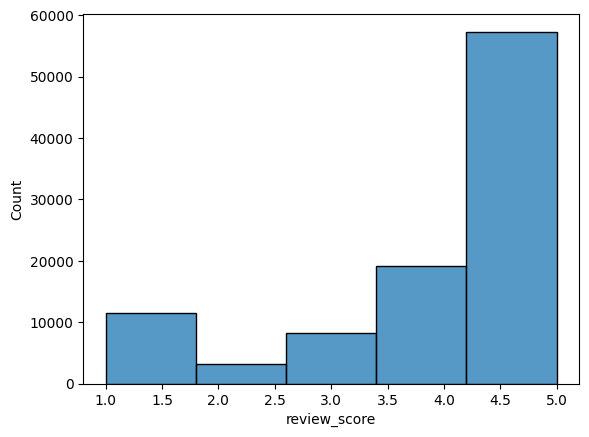

In [5]:
sns.histplot(data=data["order_reviews"], x="review_score", bins=5)

❓ Plot a histogram of `order_status` <br/>

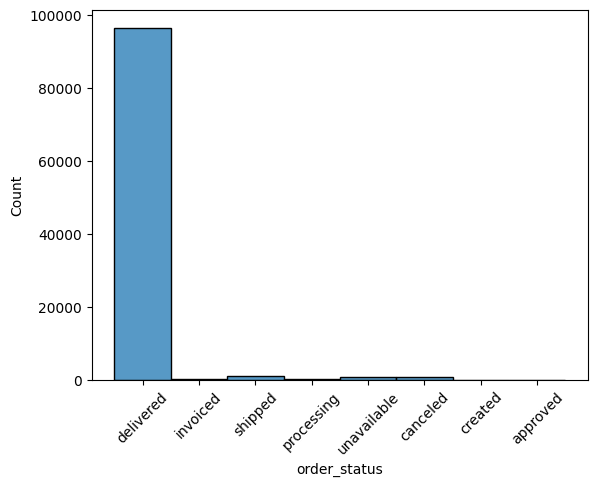

In [6]:
sns.histplot(data=data["orders"], x="order_status")
plt.xticks(rotation=45);


❓ How many of them are delivered ? shipped ? canceled ? ...

In [7]:
data["orders"]["order_status"].value_counts()


delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

💡 We already know - from our data schema - that each `review` has a unique `order`.

🤔 Do all `orders` have a `review`?

<details>
    <summary><i>▸ Hint</i></summary>

You can use `pd.Series.isna().sum()` to count the number of NaN values in a series
</details>

In [8]:
all_orders_and_reviews = data["order_reviews"].merge(data["orders"], how="outer", on="order_id")
all_orders_and_reviews["review_id"].isna().sum()

768

In [9]:
reviews_df = data["order_reviews"]
repeated_order_ids = reviews_df[reviews_df.duplicated(subset=['order_id'])].sort_values(by="order_id", axis=0)
print(repeated_order_ids.shape[0])
repeated_order_ids["order_id"].nunique()
#repeated_order_ids.head()

reviews_df["order_id"].value_counts()

551


c88b1d1b157a9999ce368f218a407141    3
8e17072ec97ce29f0e1f111e598b0c85    3
df56136b8031ecd28e200bb18e6ddb2e    3
03c939fd7fd3b38f8485a0f95798f1f6    3
5cb890a68b91b6158d69257e4e2bc359    2
                                   ..
5b4e9a12d219f34f5c2de9f8d620b19d    1
a6da096d974acc000962856d7386448a    1
75e0647c26de647eca3421e9cc66c9da    1
bad0467c52f23cdc71e9fa139d4a8afd    1
90531360ecb1eec2a1fbb265a0db0508    1
Name: order_id, Length: 98673, dtype: int64

If some orders were not reviewed, count and group them per `order_status`.

In [10]:
all_orders_and_reviews = data["order_reviews"].merge(data["orders"], how="outer", on="order_id")
orders_without_reviews = all_orders_and_reviews[all_orders_and_reviews["review_id"].isna()]

# remove the empty review columns
orders_without_reviews.dropna(how='all', axis=1, inplace=True)


orders_without_reviews.groupby("order_status").count()

/tmp/ipykernel_29482/1681274554.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_without_reviews.dropna(how='all', axis=1, inplace=True)


,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,,,,
canceled,20,20,20,17,10,0,20
created,2,2,2,0,0,0,2
delivered,646,646,646,646,646,646,646
invoiced,5,5,5,5,0,0,5
processing,6,6,6,6,0,0,6
shipped,75,75,75,75,75,0,75
unavailable,14,14,14,14,0,0,14


## 2 - Evolution of key business metrics over the past 14 months

## Metrics 

1. Which metric would you use as a `key business output metric`for Olist  📈 ? 
2.  Which metric would you use to measure that a customer had a `good experience with Olist` 🙂 ? 
3. Which metric would you use to measure `shipping delay` 🕗?

For each metric, plot a trend line over time.

### Metric 1: Order numbers

❓ Plot the weekly number of total orders per week (to check how business is going)  


In [34]:
orders_with_weeks = data["orders"][["order_id","order_purchase_timestamp"]]
orders_with_weeks["order_purchase_timestamp"] = pd.to_datetime(orders_with_weeks["order_purchase_timestamp"])
orders_by_week = orders_with_weeks.set_index(
    "order_purchase_timestamp").resample(
        "W").count().reset_index()

orders_by_week.info(1)

orders_by_week.head(1)


#orders_by_week = orders_with_weeks.groupby(pd.Grouper(key='timestamp', freq='W')).count().reset_index()
#orders_by_week = orders_with_weeks.resample("")
#orders_by_week["week"] = orders_with_weeks["timestamp"].dt.strftime("%Y-%U")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_purchase_timestamp  112 non-null    datetime64[ns]
 1   order_id                  112 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


/tmp/ipykernel_29482/1730046401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_with_weeks["order_purchase_timestamp"] = pd.to_datetime(orders_with_weeks["order_purchase_timestamp"])


,order_purchase_timestamp,order_id
0,2016-09-04,1


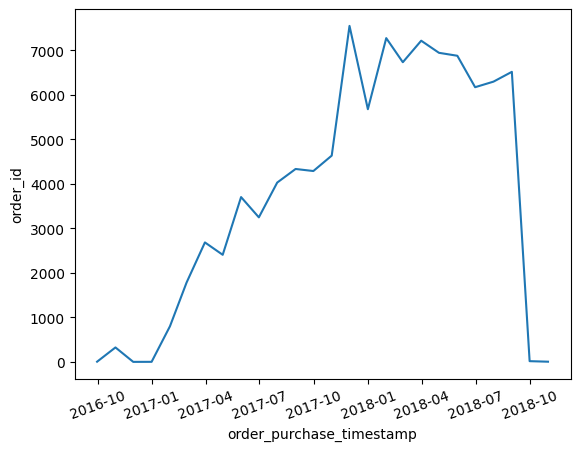

In [32]:
sns.lineplot(data=orders_by_week, x="order_purchase_timestamp", y="order_id")
plt.xticks(rotation=20);


❓ Visualize the weekly number of non-delivered orders (to check for any potential issues)

<details>
    <summary><i>▸ Hint </i></summary>    
    
* Convert dates to Python `datetime` objects  
* You can use the built-in `pandas.Series.resample() tool from `pandas` to group your dataset by weeks
    
</details>

In [ ]:
# YOUR CODE HERE

### Metric 1-bis (optional): Total payment values
❓ After plotting the total number of orders, we could also have a look at the weekly sum of `payment_value` in `BRL` to approximate Olist's weekly revenues.

In [ ]:
# YOUR CODE HERE

💡 Merge the `payments` dataset with the `orders` dataset to collect the date of each payment.

In [ ]:
# YOUR CODE HERE

⌛️ Once again, do not forget to handle datetimes properly

In [ ]:
# YOUR CODE HERE

📈 Visualize the number of orders and total amount of payments per week

In [ ]:
# YOUR CODE HERE

📈 *(Optional)* Plot the weekly number of orders and payments again with techniques you learned during the `Data Visualization` module :)

In [ ]:
# YOUR CODE HERE

### Metric 2: Customer Satisfaction
❓ How does the `customer satisfaction` evolve on a monthly basis ? Use the mean average `review_score` to illustrate the customer satisfaction.

👉 Load the `reviews` :

In [ ]:
# YOUR CODE HERE

⌛️ If you need to handle datetime, do it.

In [ ]:
# YOUR CODE HERE

📉 Plot the customer satisfaction evolution over time

In [ ]:
# YOUR CODE HERE

📉 *(Optional)* Plot the customer satisfaction evolution over time again with techniques you learned during the Data Visualization module :)

In [ ]:
# YOUR CODE HERE

### Metric 3: Shipping delay

❓Create two new metrics, `delay_vs_expected` and `wait_time` in ***days***, from the `orders` dataset, and plot their historical evolution on a weekly basis to detect trends

<details>
    <summary>▸ <i>Hint</i></summary>

    
Ask `StackOverflow` to help you compute differences between `datetime`s in Python!
</details>

🛒 Let's focus on delivered orders so that we can compute the shipping delays:

In [ ]:
# YOUR CODE HERE

⌛️ Datetime problems again ? Fix them ;)

In [ ]:
# YOUR CODE HERE

👉 Compute the delay between the actual delivery date and the ETA for each order.

In [ ]:
# YOUR CODE HERE

👉 Compute the waiting time between the actual delivery date and the moment a customer ordered their items

In [ ]:
# YOUR CODE HERE

⌛️ How many orders were delivered later than expected ? <br/>
*You can also give an answer in terms of percentage if you prefer.*
<details>
    <summary><i>▸ Hint </i></summary>

    
You can create a `boolean_feature` which is :
* True when actual_delivered_date > ETA $\leftrightarrow$ actual_delivered_date - ETA > 0
* False otherwise
    
</details>




In [ ]:
# YOUR CODE HERE

* On average, 8% of the orders are delivered after the ETA ⌛️

* Let's find which weeks were the worst 👇
    1. Aggregate the dataset per week
    2. Compute the percentage of orders delivered lately each week

In [ ]:
# YOUR CODE HERE

📈 Plot the `number of delays` and `percentage of delayed orders` per week

In [ ]:
# YOUR CODE HERE

#### Delay Analysis

📈 📉 From the previous graph, Olist experienced major lateness issues on 3-4 weeks ⚠️...

👉 Let's deep dive into these peaks of lateness.

❓ Create a dataframe (with weeks as indexes ) with the following columns:
* number of delays
* number of orders
* percentage of delayed orders

In [ ]:
# YOUR CODE HERE

❓ Create sub-dataframes to seperate these weeks into subgroups.

A suggestion:
- 20% and more
- 15-20%
- 10-15%
- 5-10%
- 5% and less